In [1]:
import os
# move 2 directories up
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from joblib import dump
from scipy.stats import norm, multivariate_normal
import lightgbm as lgb
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pickle as pkl
import joblib as joblib
target = 'net_target+1'

In [44]:
power = pd.read_csv('debug_logs/real_power_point_9000_1.csv')
power = power.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
power = power.sort_values(by=['time_step', 'building'])
power['building'] = power['building'].str[-1].astype(int)
power = power[power['time_step'] != -1]
lead_times = ['net_target+'+str(i) for i in range(24)]
# upload min-max scaler from scalers folders with .save extension
scalers = [joblib.load(f'scalers/scaler_net_{k}.save') for k in range(1, 6)]
power_norm = pd.DataFrame()
for building in range(5):
    power_norm_temp = pd.DataFrame()
    power_norm_temp['time_step'] = power.loc[power['building'] == building, 'time_step']
    power_norm_temp['building'] = building
    power_norm_temp['net_target'] = power.loc[power['building'] == building, 'net_target']
    for i, lead_time in enumerate(lead_times):
        power_norm_temp[lead_time] = power_norm_temp['net_target'].shift(-int(i))
        # noramalize using the scaler 
        power_norm_temp[lead_time] = scalers[building].transform(power_norm_temp[lead_time].values.reshape(-1, 1))
    power_norm = pd.concat([power_norm, power_norm_temp], axis=0)
power_norm = power_norm.dropna()
power_norm = power_norm.sort_values(by=['time_step', 'building'])
# drop the net_target column
power_norm = power_norm.drop(columns=['net_target'])
# set the index to time_step and building
power_norm = power_norm.set_index(['time_step', 'building'])
power_norm

net_target+0  net_target+1  net_target+2  net_target+3  \
time_step building                                                           
0         0             0.383397      0.381964      0.382273      0.437649   
          1             0.483257      0.452162      0.387754      0.387709   
          2             0.409185      0.409185      0.409185      0.409185   
          3             0.631288      0.448667      0.446456      0.444920   
          4             0.445060      0.443450      0.447577      0.444650   
...                          ...           ...           ...           ...   
8735      0             0.446581      0.359917      0.361038      0.359627   
          1             0.589339      0.384510      0.411996      0.414704   
          2             0.499823      0.464959      0.463450      0.466443   
          3             0.830277      0.652891      0.711623      0.462304   
          4             0.548914      0.505189      0.499658      0.456720   

                    net_target+4  net_target+5  net_target+6  net_target+7  \
time_step building                                                           
0         0             0.418428      0.466455      0.341153      0.267408   
          1             0.499620      0.362711      0.389762      0.454266   
          2             0.409185      0.405686      0.391654      0.404757   
          3             0.447418      0.468951      0.476724      0.659505   
          4             0.418376      0.427833      0.414805      0.371538   
...                          ...           ...           ...           ...   
8735      0             0.360479      0.360861      0.376404      0.328893   
          1             0.543799      0.365497      0.361903      0.350758   
          2             0.458748      0.457579      0.449467      0.439400   
          3             0.480714      0.633036      0.447497      0.495956   
          4             0.454899      0.427567      0.436070      0.361513   

                    net_target+8  net_target+9  ...  net_target+14  \
time_step building                              ...                  
0         0             0.207303      0.153254  ...       0.258309   
          1             0.411655      0.471360  ...       0.433012   
          2             0.297595      0.271606  ...       0.227862   
          3             0.601217      0.446007  ...       0.140766   
          4             0.348402      0.358594  ...       0.366649   
...                          ...           ...  ...            ...   
8735      0             0.275541      0.224087  ...       0.292499   
          1             0.364814      0.488771  ...       0.434025   
          2             0.400822      0.325242  ...       0.227845   
          3             0.650026      0.441110  ...       0.413034   
          4             0.278724      0.204954  ...       0.445852   

                    net_target+15  net_target+16  net_target+17  \
time_step building                                                
0         0              0.283984       0.314944       0.401013   
          1              0.348603       0.258984       0.246717   
          2              0.185584       0.196730       0.296364   
          3              0.128045       0.381866       0.409008   
          4              0.363123       0.383307       0.670630   
...                           ...            ...            ...   
8735      0              0.319800       0.379287       0.537810   
          1              0.450167       0.173749       0.197350   
          2              0.327718       0.341778       0.445648   
          3              0.347415       0.416779       0.516825   
          4              0.527084       0.589056       0.771749   

                    net_target+18  net_target+19  net_target+20  \
time_step building                                                
0         0              0.396873       0.621485       0.742961   
      

In [45]:
preds = pd.read_csv('debug_logs/scenarios_point_9000_1.csv')
# drop the scenario column
preds = preds.drop(columns=['scenario'])
pred_cols = preds.columns[2:]
# normalize the predictions using the same scalers
# noramalize using the scaler 
for building in preds['building'].unique():
    for col in pred_cols:
        preds.loc[preds['building'] == building, col] = scalers[building].transform(preds.loc[preds['building'] == building, col].values.reshape(-1, 1))
# make an index from the time_step and building columns
preds = preds.set_index(['time_step', 'building'])
# keep only indexes that are in the power_norm dataframe
preds = preds[preds.index.isin(power_norm.index)]
preds

+0h       +1h       +2h       +3h       +4h  \
time_step building                                                     
0         0         0.337543  0.362115  0.381869  0.398857  0.378159   
          1         0.360467  0.376461  0.379747  0.400681  0.397429   
          2         0.332508  0.364875  0.369954  0.386128  0.373753   
          3         0.456125  0.459011  0.468694  0.469674  0.471600   
          4         0.340167  0.375506  0.380362  0.391342  0.383284   
...                      ...       ...       ...       ...       ...   
8735      0         0.418122  0.399566  0.403788  0.401521  0.402699   
          1         0.591249  0.592907  0.414990  0.503345  0.443929   
          2         0.500516  0.481412  0.469667  0.468716  0.461958   
          3         0.669387  0.645312  0.528609  0.502763  0.583617   
          4         0.489134  0.471643  0.470483  0.470062  0.473600   

                         +5h       +6h       +7h       +8h       +9h  ...  \
time_step building                                                    ...   
0         0         0.399257  0.365445  0.378040  0.392255  0.381656  ...   
          1         0.422327  0.388769  0.388665  0.420701  0.402745  ...   
          2         0.382433  0.339343  0.344113  0.349784  0.340160  ...   
          3         0.511880  0.493160  0.483788  0.509505  0.487440  ...   
          4         0.398777  0.374586  0.384278  0.399252  0.392616  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      0         0.404125  0.415404  0.404544  0.347046  0.328254  ...   
          1         0.424389  0.435043  0.413541  0.408895  0.392727  ...   
          2         0.463397  0.493477  0.478628  0.442242  0.389576  ...   
          3         0.482115  0.498221  0.561728  0.450848  0.534929  ...   
          4         0.449506  0.436091  0.380447  0.341312  0.339928  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0         0.406578  0.420475  0.418172  0.416510  0.413392   
          1         0.430514  0.441428  0.425611  0.433165  0.416670   
          2         0.379131  0.393244  0.397835  0.394684  0.390628   
          3         0.495044  0.499957  0.494277  0.481001  0.509628   
          4         0.394861  0.408914  0.403763  0.403944  0.403069   
...                      ...       ...       ...       ...       ...   
8735      0         0.336510  0.361663  0.459232  0.485990  0.502612   
          1         0.425352  0.511351  0.473923  0.450808  0.482282   
          2         0.387658  0.437567  0.417819  0.451974  0.470716   
          3         0.487364  0.484280  0.473987  0.576278  0.573706   
          4         0.478839  0.553580  0.605254  0.607755  0.621418   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         0.409133  0.404885  0.404796  0.385388  0.393028  
          1         0.426083  0.394167  0.427903  0.396656  0.404514  
          2         0.387599  0.380444  0.371894  0.358757  0.372502  
          3         0.475798  0.461178  0.490504  0.456085  0.481419  
          4         0.396225  0.392539  0.393665  0.385148  0.391920  
...                      ...       ...       ...       ...       ...  
8735      0         0.509143  0.507823  0.484817  0.475181  0.433707  
          1         0.492283  0.486452  0.496203  0.509236  0.590143  
          2         0.516209  0.498944  0.508877  0.499420  0.493108  
          3         0.639093  0.495373  0.515627  0.598961  0.630633  
          4         0.615761  0.469281  0.496168  0.541796  0.511303  

[43680 rows x 24 columns]

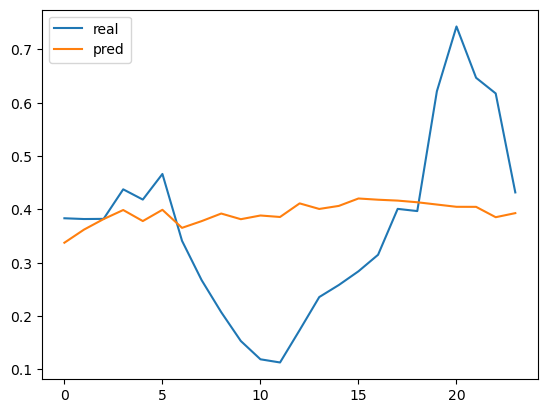

In [46]:
# plot the first row of power_norm
plt.plot(list(range(24)),power_norm.iloc[0, :].T, label='real')
# plot the first row of preds
plt.plot(list(range(24)),preds.iloc[0, :].T, label='pred')
plt.legend()
plt.show()

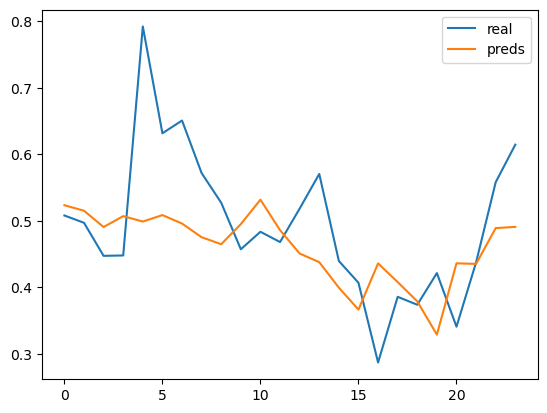

In [47]:
# do the same for the last row
plt.plot(list(range(24)),power_norm.iloc[5612, :].T, label='real')
plt.plot(list(range(24)),preds.iloc[5612, :].T, label='preds')
plt.legend()
plt.show()

In [33]:
# find residuals between power and preds
residuals = power_norm.copy()
for i in range(1, 25):
    col_preds = '+{}h'.format(i-1)
    col_power = 'net_target+{}'.format(i)
    col_residuals = 'residuals+{}'.format(i)
    residuals[col_residuals] = residuals[col_power] - preds[col_preds]
# drop the power columns
residuals = residuals.drop(columns=[col for col in residuals.columns if 'net_target' in col])
residuals['Hour'] = (residuals.index.get_level_values(0)) % 24
# move hour column to the first position
cols = residuals.columns.tolist()
cols = cols[-1:] + cols[:-1]
residuals = residuals[cols]
residuals

Hour  residuals+1  residuals+2  residuals+3  residuals+4  \
time_step building                                                             
0         0            0     0.044421     0.020158     0.055780     0.019571   
          1            0     0.091694     0.011293     0.007962     0.098939   
          2            0     0.076677     0.044310     0.039232     0.023058   
          3            0    -0.007459    -0.012555    -0.023774    -0.022256   
          4            0     0.103282     0.072072     0.064287     0.027034   
...                  ...          ...          ...          ...          ...   
8734      0           22    -0.049359    -0.098518    -0.032851    -0.053820   
          1           22     0.125750    -0.116524    -0.121666    -0.003747   
          2           22    -0.005760    -0.037855    -0.018858    -0.005403   
          3           22     0.222813     0.013444     0.072648    -0.067471   
          4           22    -0.026232     0.009484     0.024762    -0.026325   

                    residuals+5  residuals+6  residuals+7  residuals+8  \
time_step building                                                       
0         0            0.088297    -0.058105    -0.098037    -0.170737   
          1           -0.034718    -0.032565     0.065497     0.022990   
          2            0.031934     0.009221     0.065414    -0.046518   
          3           -0.002649    -0.035155     0.166345     0.117430   
          4            0.044549     0.016028    -0.003047    -0.035876   
...                         ...          ...          ...          ...   
8734      0           -0.053804    -0.066100    -0.043391    -0.104467   
          1            0.077937    -0.043585    -0.036752    -0.041106   
          2           -0.011685    -0.005973    -0.015499    -0.055297   
          3           -0.012734     0.061140    -0.023495     0.014778   
          4           -0.030950    -0.059017    -0.022001    -0.084120   

                    residuals+9  ...  residuals+15  residuals+16  \
time_step building               ...                               
0         0           -0.239001  ...     -0.122595     -0.105531   
          1            0.050659  ...     -0.081910     -0.182444   
          2           -0.078178  ...     -0.193548     -0.196513   
          3           -0.063498  ...     -0.366999     -0.118091   
          4           -0.040658  ...     -0.031738     -0.025607   
...                         ...  ...           ...           ...   
8734      0           -0.139705  ...     -0.084679     -0.042071   
          1           -0.008485  ...      0.074454      0.059542   
          2           -0.078628  ...     -0.144261     -0.060180   
          3            0.098668  ...     -0.076570     -0.128882   
          4           -0.116109  ...     -0.046369      0.037098   

                    residuals+17  residuals+18  residuals+19  residuals+20  \
time_step building                                                           
0         0            -0.017158     -0.019637      0.208093      0.333827   
          1            -0.178894     -0.116122     -0.050256      0.081855   
          2            -0.101471      0.008654      0.018557      0.021586   
          3            -0.085270     -0.073314      0.075106      0.269180   
          4             0.266867      0.221966      0.165328      0.311198   
...                          ...           ...           ...           ...   
8734      0            -0.010678      0.044573     -0.022075     -0.113706   
          1            -0.291967     -0.241119     -0.146593      0.048760   
          2            -0.100967      0.023609      0.047597      0.116337   
          3            -0.056443      0.051035     -0.022081      0.017397   
          4             0.025507      0.157520      0.233317      0.078581   

                    residuals+21  residuals+22  residuals+23  residuals+24  
time_step building                     

In [34]:
# find a correlation matrix between lead times
corr = residuals.iloc[:, 1:].corr()
# for each hour, find the correlation between the lead times
corr_hour = {}
stds = {}
means = {}
for hour in range(0, 24):
    corr_hour[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 1:].corr()
    stds[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 1:].std()
    means[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 1:].mean()
# save the correlation matrix and the standard deviations to pickle files
# with open('models/residuals_corr/corr.pkl', 'wb') as f:
#     pkl.dump(corr, f)
# with open('models/residuals_corr/corr_hour.pkl', 'wb') as f:
#     pkl.dump(corr_hour, f)

In [35]:
# convert the correlation matrix for each hour to a covariance matrix
cov_hour = {}
mvn_hour = {}
for hour in range(0, 24):
    cov_hour[hour] = np.outer(stds[hour], stds[hour]) * corr_hour[hour]
    mvn_hour[hour] = multivariate_normal(mean=[0]*24, cov=cov_hour[hour])
# save the covariance matrix to a pickle file
# with open('models/residuals_corr/cov_hour.pkl', 'wb') as f:
#     pkl.dump(cov_hour, f)
# save the multivariate normal distributions to pickle files
# with open('models/residuals_corr/mvn_hour.pkl', 'wb') as f:
#     pkl.dump(mvn_hour, f)

In [36]:
rv_mvnorm = multivariate_normal([0]*24, cov_hour[15])
simulation_mvnorm = rv_mvnorm.rvs(10)
simulation_uniform = pd.DataFrame(data=simulation_mvnorm, 
                                              columns = corr.columns)
simulation_uniform

,residuals+1,residuals+2,residuals+3,residuals+4,residuals+5,residuals+6,residuals+7,residuals+8,residuals+9,residuals+10,...,residuals+15,residuals+16,residuals+17,residuals+18,residuals+19,residuals+20,residuals+21,residuals+22,residuals+23,residuals+24
0,-0.000341,0.059098,-0.000047,0.040890,-0.022178,0.112501,0.034981,-0.052988,0.073128,-0.059557,...,-0.018739,-0.059723,-0.017264,-0.105306,-0.017198,-0.150419,-0.155222,-0.192337,0.020814,-0.049565
1,0.314546,0.116260,0.070663,0.132751,0.153142,-0.037823,-0.069500,0.133951,0.140187,0.154509,...,0.087563,0.128180,0.105465,0.145141,0.054393,0.022201,0.093988,0.072446,0.162108,0.027609
2,0.046899,-0.030915,0.066826,-0.084917,-0.027629,0.022253,-0.096645,-0.095614,-0.057649,0.011030,...,0.032378,-0.019754,-0.029666,-0.047463,-0.005557,-0.159531,-0.118837,-0.154980,-0.052535,-0.112279
3,0.044125,-0.120546,-0.040561,-0.057809,0.047623,0.025965,-0.041487,-0.010995,-0.045945,-0.005163,...,-0.004162,0.030836,0.113759,0.052174,0.055481,0.092473,0.097121,-0.007815,0.120046,0.125799
4,0.102486,0.138518,0.043542,0.019206,0.028698,0.021507,-0.009653,-0.063051,0.091426,0.127110,...,0.070618,-0.044783,0.031616,0.095639,0.147594,0.160846,0.027244,0.053163,0.130186,0.208747
5,-0.097222,0.071781,0.154211,-0.006216,0.028670,0.002549,0.015377,-0.004051,-0.098652,-0.066846,...,-0.099649,-0.081157,-0.110805,-0.062564,0.082558,0.176030,0.187335,0.036791,-0.101255,-0.012811
6,-0.191800,-0.169675,0.044957,0.032631,0.074479,-0.141667,-0.292783,-0.217108,-0.080139,-0.069571,...,0.005191,0.024423,-0.035068,0.105368,-0.095229,-0.139976,-0.034599,-0.138099,-0.136680,-0.128129
7,0.022700,0.022322,0.084674,0.087570,0.001498,-0.004959,0.092923,0.031452,0.005725,0.054979,...,-0.026468,-0.008003,-0.096819,0.085071,0.085705,0.109644,0.172373,0.210073,0.127841,0.039936
8,-0.082833,-0.023885,-0.019278,-0.042712,-0.018968,-0.264027,-0.229456,-0.080407,-0.219036,-0.079246,...,-0.159050,-0.039146,-0.004761,-0.065565,0.040799,-0.001410,-0.036022,0.057774,0.110705,0.071477
9,-0.045959,0.144940,0.237846,-0.021811,0.058671,0.039001,0.205044,0.037704,0.005653,0.012511,...,0.024777,-0.063592,0.080703,-0.006710,0.041022,0.047462,0.167241,0.144340,0.112710,0.186869


In [41]:
residuals

Hour  residuals+1  residuals+2  residuals+3  residuals+4  \
time_step building                                                             
0         0            0     0.044421     0.020158     0.055780     0.019571   
          1            0     0.091694     0.011293     0.007962     0.098939   
          2            0     0.076677     0.044310     0.039232     0.023058   
          3            0    -0.007459    -0.012555    -0.023774    -0.022256   
          4            0     0.103282     0.072072     0.064287     0.027034   
...                  ...          ...          ...          ...          ...   
8734      0           22    -0.049359    -0.098518    -0.032851    -0.053820   
          1           22     0.125750    -0.116524    -0.121666    -0.003747   
          2           22    -0.005760    -0.037855    -0.018858    -0.005403   
          3           22     0.222813     0.013444     0.072648    -0.067471   
          4           22    -0.026232     0.009484     0.024762    -0.026325   

                    residuals+5  residuals+6  residuals+7  residuals+8  \
time_step building                                                       
0         0            0.088297    -0.058105    -0.098037    -0.170737   
          1           -0.034718    -0.032565     0.065497     0.022990   
          2            0.031934     0.009221     0.065414    -0.046518   
          3           -0.002649    -0.035155     0.166345     0.117430   
          4            0.044549     0.016028    -0.003047    -0.035876   
...                         ...          ...          ...          ...   
8734      0           -0.053804    -0.066100    -0.043391    -0.104467   
          1            0.077937    -0.043585    -0.036752    -0.041106   
          2           -0.011685    -0.005973    -0.015499    -0.055297   
          3           -0.012734     0.061140    -0.023495     0.014778   
          4           -0.030950    -0.059017    -0.022001    -0.084120   

                    residuals+9  ...  residuals+15  residuals+16  \
time_step building               ...                               
0         0           -0.239001  ...     -0.122595     -0.105531   
          1            0.050659  ...     -0.081910     -0.182444   
          2           -0.078178  ...     -0.193548     -0.196513   
          3           -0.063498  ...     -0.366999     -0.118091   
          4           -0.040658  ...     -0.031738     -0.025607   
...                         ...  ...           ...           ...   
8734      0           -0.139705  ...     -0.084679     -0.042071   
          1           -0.008485  ...      0.074454      0.059542   
          2           -0.078628  ...     -0.144261     -0.060180   
          3            0.098668  ...     -0.076570     -0.128882   
          4           -0.116109  ...     -0.046369      0.037098   

                    residuals+17  residuals+18  residuals+19  residuals+20  \
time_step building                                                           
0         0            -0.017158     -0.019637      0.208093      0.333827   
          1            -0.178894     -0.116122     -0.050256      0.081855   
          2            -0.101471      0.008654      0.018557      0.021586   
          3            -0.085270     -0.073314      0.075106      0.269180   
          4             0.266867      0.221966      0.165328      0.311198   
...                          ...           ...           ...           ...   
8734      0            -0.010678      0.044573     -0.022075     -0.113706   
          1            -0.291967     -0.241119     -0.146593      0.048760   
          2            -0.100967      0.023609      0.047597      0.116337   
          3            -0.056443      0.051035     -0.022081      0.017397   
          4             0.025507      0.157520      0.233317      0.078581   

                    residuals+21  residuals+22  residuals+23  residuals+24  
time_step building                     

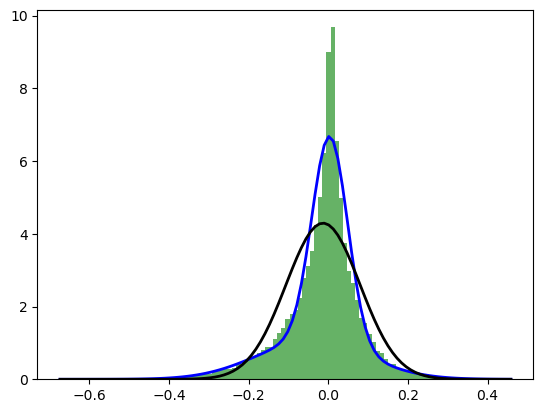

In [28]:
# estimate by a normal distribution
mu, std = norm.fit(data_train['residual'])
# fit to a gaussian mixture model
gmm = GaussianMixture(n_components=2).fit(data_train['residual'].values.reshape(-1, 1))
# plot the histogram and the normal distribution
plt.hist(data_train['residual'], bins=100, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = np.exp(gmm.score_samples(x.reshape(-1,1)))
# plot the PDF
plt.plot(x, y, 'b-', lw=2)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

In [43]:
# find gmm for residuals for every Hour
gmm_dict = {}
for hour in data_train['Hour'].unique():
    gmm_dict[hour] = GaussianMixture(n_components=2).fit(residuals.loc[residuals['Hour'] == hour, 'residual+1'].values.reshape(-1, 1))
    # save the gmm parameters with joblib
    dump(gmm_dict[hour], 'models/gmm/gmm_residual_hour_{}.joblib'.format(int(hour)))
    # plot the histogram and the gmm
    plt.hist(residuals.loc[residuals['Hour'] == hour, 'residual'], bins=100, density=True, alpha=0.6, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = np.exp(gmm_dict[hour].score_samples(x.reshape(-1,1)))
    # plot the PDF
    plt.plot(x, y, 'b-', lw=2)
    plt.show()

NameError: name 'data_train' is not defined

<AxesSubplot:xlabel='Month'>

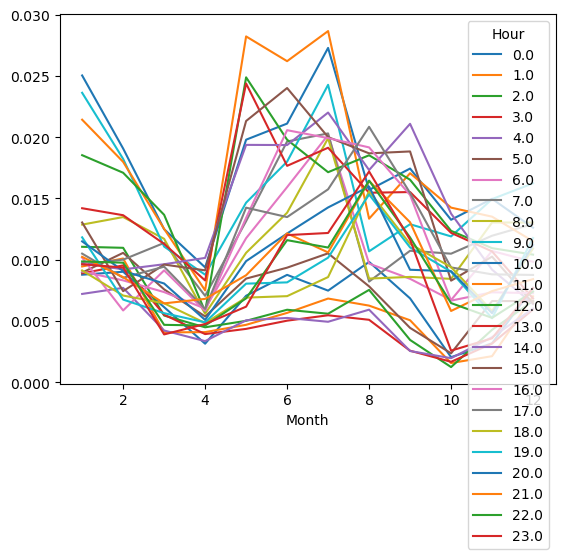

In [5]:
# show variance by hour and month
data_train.groupby(['Month', 'Hour']).var()[target].unstack().plot()

In [11]:
# calculate variance by hour and month
var_df = data_train.groupby(['Month', 'Hour']).var()[target].unstack()
# turn index and column names to int
var_df.index = var_df.index.astype(int)
var_df.columns = var_df.columns.astype(int)
var_df
# save to csv to data folder
var_df.to_csv('data/variance_hour_month.csv')

In [8]:
data_train.groupby(['Month', 'Hour']).var()[target].unstack()

Hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
Month,,,,,,,,,,,,,,,,,,,,,
1.0,0.008780,0.009453,0.011057,0.008894,0.007211,0.008951,0.009030,0.009625,0.012868,0.023625,...,0.009749,0.013043,0.010172,0.010501,0.009127,0.011829,0.011501,0.010236,0.009861,0.009635
2.0,0.009020,0.010102,0.010975,0.009540,0.007707,0.010563,0.008317,0.010008,0.013484,0.018229,...,0.009212,0.007439,0.005861,0.008532,0.007080,0.006751,0.009089,0.008583,0.009761,0.009362
3.0,0.006133,0.004070,0.005447,0.005516,0.004225,0.007584,0.007361,0.011373,0.011708,0.011075,...,0.009634,0.009608,0.009134,0.009434,0.006447,0.005640,0.008062,0.006441,0.004689,0.003908
4.0,0.003149,0.004095,0.004488,0.003935,0.003359,0.005374,0.006013,0.007058,0.005587,0.008783,...,0.010151,0.009136,0.005823,0.005992,0.004837,0.004895,0.005090,0.006808,0.004631,0.004757
5.0,0.007062,0.004691,0.005017,0.004359,0.005061,0.008463,0.011760,0.013148,0.010566,0.014658,...,0.019374,0.021323,0.013415,0.014250,0.006910,0.008050,0.009889,0.008736,0.006849,0.006172
6.0,0.008767,0.005664,0.005921,0.005029,0.005252,0.009354,0.015926,0.019651,0.013838,0.018007,...,0.019360,0.024014,0.020574,0.013483,0.007030,0.008154,0.012141,0.012149,0.011599,0.012011
7.0,0.007481,0.006834,0.005596,0.005469,0.004940,0.010525,0.020187,0.020309,0.019917,0.024276,...,0.022012,0.020010,0.019927,0.015748,0.008588,0.010170,0.014269,0.010597,0.010995,0.012185
8.0,0.009825,0.006257,0.007541,0.005101,0.005927,0.007829,0.009685,0.008221,0.008466,0.010688,...,0.017321,0.018683,0.019169,0.020845,0.015580,0.015326,0.015972,0.016433,0.016456,0.017201
9.0,0.006849,0.005061,0.003456,0.002577,0.002552,0.004440,0.008445,0.010735,0.008599,0.012900,...,0.021093,0.018838,0.015282,0.015449,0.011290,0.011006,0.009183,0.013058,0.011818,0.011635
